In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
from scipy import optimize
from scipy.optimize import minimize
import re
import sys
import subprocess
import math

In [2]:
class methyl_MF():
    
    pre=2*np.pi*167000 # prefactor based on physical constants
    A = 3./16.*pre**2 # prefactor A for Jomega calculations
    B = 1./32.*pre**2 # prefactor B for Jomega calculations
    pico=1.*10**(-12) # picoseconds
    frequency = np.linspace(0, 2*10**9, 100) # Hz
    
    def __init__(self,methyl_numb=0,rates=[],rates_err=[]):
        
        self.methyl_numb = methyl_numb
        self.rates = []
        self.rares_err = []
    
    def get_freq(self,D_Larmor_field1=92.1298227037992, D_Larmor_field2=115.138869111022):
        # Larmor frquency of deuterium
        # frequencies of spectral density used for the fit / usually frequencies measured in NMR
        #D_freq_600=92.1298227037992 # MHz @600 MHz (14.1 T) 
        #D_freq_750=115.138869111022 # MHz @750 HHz (17.6 T)
        
        omega_D_field1=2.*np.pi*D_Larmor_field1*10**6 # angular frequence rad/sec
        omega_D_field2=2.*np.pi*D_Larmor_field2*10**6 # angular frequence rad/sec 
        
        # create array with five frequences  
        measuredfreq_field1=np.array([i*omega_D_field1 for i in [0,1,2]])
        measuredfreq_field2=np.array([i*omega_D_field2 for i in [0,1,2]])
        
        measuredfreq = np.array([measuredfreq_field1[0],measuredfreq_field1[1], measuredfreq_field2[1],
                       measuredfreq_field1[2], measuredfreq_field2[2]])
        
        return measuredfreq
    
    def get_rates (self,methyl_numb,relax_times_exp):

        times=relax_times_exp.iloc[methyl_numb][::2].values # in ms
        self.rates = 1/(times*0.001) 
        
        return self.rates
        
    def get_rates_err (self,methyl_numb,relax_times_exp):

        errors = relax_times_exp.iloc[methyl_numb][1::2].values # in ms
        self.rares_err = np.divide(errors/0.001, times**2) 
        
        return self.rares_err
    
    def get_rates_and_err (self,methyl_numb,relax_times_exp):

        times=relax_times_exp.iloc[methyl_numb][::2].values # in ms
        errors = relax_times_exp.iloc[methyl_numb][1::2].values # in ms
        self.rates = 1/(times*0.001) 
        self.rares_err = np.divide(errors/0.001, times**2) 
        
        return self.rates, self.rares_err

    
    def get_methyl(self,methID,tumbling_file):
        
        methID_dict = {"Ala":"ALA", "Ile":"ILE", "Leu":"LEU", "Met":"MET", "Thr":"THR", "Val":"VAL",
               "Cb":"-CB", "Hb":"HB", "Cg1":"-CG1","Cg2":"-CG2", "Hg1":"HG1","Hg2":"HG2","Cd1":"-CD1", "Hd1":"HD1",
               "Cd2":"-CD2", "Hd2":"HD2", "Ce":"-CE", "He":"HE"}
        
        match = re.search('(\d+)(\w{3})(\w+)_\d+\w{3}(\w+)', methID)
        resN = match.group(1) if match else None
        resName = match.group(2) if match else None
        carbon = match.group(3) if match else None
        hydrogen = match.group(4) if match else None
        
        #methIDnew= " %s%s-%s%s" % (resName, resN, carbon, hydrogen)
        
        meth3ID = str(methID_dict[match.group(2)] + match.group(1) + methID_dict[match.group(3)] + methID_dict[match.group(4)])
        if resName=="Ile" and carbon=="Cd1":
            meth3ID=meth3ID.replace("-CD1HD1","-CDHD")
             
        with open(tumbling_file) as origin_file: # extract tumbling time from external tumbling
            for line in origin_file:
                match = re.search(f'(\d+\.\d+)\s*\t*\[({meth3ID})\]', line) 
                
                methylID = match.group(2) if match else None
                if methylID:
                    for_taum = match.group(1) if match else None
                    taum=float(for_taum)*1000*methyl_MF.pico
                    
        return meth3ID, taum
    
    
    
    # methods to calculate spectral density points from methyl relaxation rates
    def J_omega_D(self,R1,R2,R3):
        return R3/(3*methyl_MF.A) - R1*0 - R2*0
 
    def J_2omega_D(self,R1,R2,R3):
        return (R1/methyl_MF.A - R3/(3*methyl_MF.A))/4 - R2*0
    def J_2omega_D_b(self,R2,R3,R4):
        return (R4/methyl_MF.A - R3/(3*methyl_MF.A))/2 - R2*0  
    
    def J_0(self,R1,R2,R3):
        return ( R2/methyl_MF.B - 5*R3/methyl_MF.A - 1.5*R1/methyl_MF.A + 0.5*R3/methyl_MF.A ) /9
    def J_0_b(self,R2,R3,R4):
        return ( R2/methyl_MF.B - 5*R3/methyl_MF.A - 3*R4/methyl_MF.A + R3/methyl_MF.A ) /9
    
    
    # methods to calculate methyl relaxation rates from spectral density points
    def R1(self,x,y,z):
        return 3./16.*methyl_MF.pre**2*(0*x+ 1*y+4*z)
    def R2(self,x,y,z):
        return 1./32.*methyl_MF.pre**2*(9*x+15*y+6*z)
    def R3(self,x,y,z):                            
        return 3./16.*methyl_MF.pre**2*(0*x+ 3*y+0*z)
    def R4(self,x,y,z):
        return 3./16.*methyl_MF.pre**2*(0*x+ 1*y+2*z)
    
    # calculate chi2 for the rates
    def CHI2(self,Rmodel,Rnmr,Rerror):
        return sum([((Rmodel[i]-Rnmr[i])/Rerror[i])**2 for i in [0,1,2]])        
    
    # Lipari-Szabo (2) function
    def LS2ns_MC(self,x,p11,p22):
        return 2./5.*(1./9.*p11*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p11)*taumps*p22/(taumps+p22+(x*taumps*p22)**2/(taumps+p22))) # Lipari-Szabo function

    # Lipari-Szabo (3) function
    def LS3ns_MC(self,x,p11,p22,p33):    
        return 2./5.*(1./9.*p11*p33/(1.+(x*p33)**2)+(1.-1./9.*p11)*p33*p22/(p33+p22+(x*p33*p22)**2/(p33+p22))) # Lipari-Szabo function
    # Calculate the uncertainty (for the fitted Jomega's)
    def ERR_MSD(self,*args):
        return np.sqrt(np.sum([(x-args[0])**2 for x in args[1:]])/(np.size(args)-2))

    
    def chi2_leave_one_out(self,nfields=2,nrates=4):
        # chi2 functions for Jomega's minimization are going to be created
        # the full chi2 function (based on all input rates: R1-R4 at two fields)will be used to define the actual parameters
        
        # according to leave-one-out algorithm a separate function for each case should be created
        # this is required to define the uncertanties of the actual fitted parameters (with S2, LS3) 
        # these functions will be compared to the full chi2 function with no leave-one-out 
        
        # all Chi2_Jpre functions should be stated explicitly and separately to be minimized;
        # equations corresponding to the guessed rates should be explicitly stated through Jomegas_pre[x],
        # since each Jomegas_pre[x] is going to be minimized
        
        #call strings based on rates (1-4) and fields (1 and 2)
        
        strR1_field1 = "\t(((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-Rates[0])/Rates_err[0])**2+\\\n"
        strR2_field1 = "\t(((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-Rates[1])/Rates_err[1])**2+\\\n" 
        strR3_field1 = "\t(((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-Rates[2])/Rates_err[2])**2+\\\n" 
        strR4_field1 = "\t(((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-Rates[3])/Rates_err[3])**2+\\\n" 
        strR1_field2 = "\t(((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-Rates[4])/Rates_err[4])**2+\\\n" 
        strR2_field2 = "\t(((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-Rates[5])/Rates_err[5])**2+\\\n" 
        strR3_field2 = "\t(((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-Rates[6])/Rates_err[6])**2+\\\n" 
        strR4_field2 = "\t(((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-Rates[7])/Rates_err[7])**2\n" 
        
        strRates = [strR1_field1,strR2_field1,strR3_field1,strR4_field1,
                    strR1_field2,strR2_field2,strR3_field2,strR4_field2]
        
        # Create a full chi2 function 
        func_top = f"def Chi2_Jpre_all (Jomegas_pre,Rates,Rates_err):"
        return_stat = "\treturn \\"
        f = open(f"./chi2_func_all.py", 'w')
        
        print(func_top,file=f) 
        print(return_stat,file=f) 
        for i in strRates:
            print (i,end='',file=f)
        print("",file=f)
        f.close()
        
        # create leave-one-out chi2 functions (leaving one experimental rate out at a time)
        rate_counter=0
        for field in range(1,nfields+1):
            for rate in range(1,nrates+1):
                if rate == nrates and field == nfields:
                    strRates[nrates*nfields-2]=strRates[nrates*nfields-2][:-3]
                #f = open(f"./chi2_func_noR{rate}_field{field}.py", 'w')
                f = open(f"./chi2_func_all.py", 'a')
                temp = strRates[rate_counter]
                strRates[rate_counter]=""
                func_top = f"def Chi2_Jpre_noR{rate}_field{field} (Jomegas_pre,Rates,Rates_err):"
                print(func_top,file=f) 
                print(return_stat,file=f) 
                for i in strRates:
                    print (i,end='',file=f)
                print("",file=f)
                strRates[rate_counter] = temp  
                rate_counter+=1
                f.close()
    
                            
    def minimize_Chi2_Jpre(self,Jomegas_pre,Chi2_Jpre):
    
        positive = { 'type': 'ineq', 'fun' : lambda x: np.array(x) }
        opt = { 'maxiter': 500 , 'disp': False}
        
        result = optimize.minimize( Chi2_Jpre, Jomegas_pre,args=(Rates,Rates_err), jac = False, constraints = positive, method = 'SLSQP', options = opt )     
        JomegaD = np.array([result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]])/self.pre**2
        
        return result, JomegaD
        
        
    def LS_fit(self,taum,measuredfreq,JomegaD):
        
        LS2 = lambda p,x: 2./5.*(1./9.*p[0]*taum/(1.+(x*taum)**2)+(1.-1./9.*p[0])*taum*p[1]/(taum+p[1]+(x*taum*p[1])**2/(taum+p[1]))) # Lipari-Szabo function
        errLS2func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
        taumps=taum/methyl_MF.pico
        p02 = [0.5, 50] # Initial guess for the parameters
        bounds2_min = [0.,0.]
        bounds2_max = [1.,taumps]
        bounds2 = [bounds2_min, bounds2_max]
        LS2ns = lambda p,x: 2./5.*(1./9.*p[0]*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p[0])*taumps*p[1]/(taumps+p[1]+(x*taumps*p[1])**2/(taumps+p[1]))) # Lipari-Szabo function in ns
        errLS2nsfunc = lambda p, x, y: LS2ns(p, x) - y # Distance to the target function
        p2 = optimize.least_squares(errLS2nsfunc, p02, bounds=bounds2, args=(measuredfreq*methyl_MF.pico, JomegaD/methyl_MF.pico)) # fit with LS2 function
        p2x=np.array([float(p2.x[0]), float(p2.x[1]*methyl_MF.pico)])
    
        ##LS3 fit
    
        LS3 = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
        errLS3func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
        p03 = [0.5, 100, 5000] # Initial guess for the parameters
        bounds3_min = [0.,0., 1000.]
        bounds3_max = [1.,500,10000]
        bounds3 = [bounds3_min, bounds3_max]
        LS3ns = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
        errLS3nsfunc = lambda p, x, y: LS3ns(p, x) - y # Distance to the target function
        p3 = optimize.least_squares(errLS3nsfunc, p03, bounds=bounds3, args=(measuredfreq*methyl_MF.pico, JomegaD/methyl_MF.pico)) # fit with LS3 function
        p3x=np.array([float(p3.x[0]), float(p3.x[1]*methyl_MF.pico), float(p3.x[2]*methyl_MF.pico)])
        
        Jw_LS2 = LS2(p2x,measuredfreq)
        Jw_LS3 = LS3(p3x,measuredfreq)
        
        return p2x, p3x, Jw_LS2, Jw_LS3
        
    def MC_sim(self,p2x,p3x,AIC_LS2,AIC_LS3,err_Jws,measuredfreq,nTrials = 4000):
        
        if AIC_LS2<=AIC_LS3: 
            LSns_MC = self.LS2ns_MC
            vGuess = [0.5,50]
        else:
            LSns_MC = self.LS3ns_MC
            vGuess = [0.5,100,5000]
           
        LSns_MC = self.LS3ns_MC
        vGuess = [0.5,100,5000]
            
        sError = err_Jws # error based on using all Jw's vs excluding obsolete Jw's. This way the error is based only on the variations in the experimental data
        aFitPars = np.array([])
        
        
        for iTrial in range(nTrials):
            xTrial = measuredfreq*methyl_MF.pico
            yGen = JomegaD/methyl_MF.pico
            yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
            # We use a try/except clause to catch pathologies
            try:                
                    vTrial, aCova = optimize.curve_fit(LSns_MC,xTrial,yTrial,vGuess)
                    
            except:
    
                continue  # This moves us to the next loop without stacking.
              
            #here follows the syntax for stacking the trial onto the running sample:
            if np.size(aFitPars) < 1:
                aFitPars=np.copy(vTrial)
            else:
                aFitPars = np.vstack(( aFitPars, vTrial ))
           
        S2_tauf_MC_std=np.array([float(np.median(aFitPars[:,0])), float(np.std(aFitPars[:,0])), \
                                 float(np.median(aFitPars[:,1])), float(np.std(aFitPars[:,1]))])
        
        if AIC_LS2<=AIC_LS3:
            S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*methyl_MF.pico])
            best_model = "LS2"
            px_min = p2x-S2_tauf_MC_stdOnly
            px_max = p2x+S2_tauf_MC_stdOnly
          
        else:
            S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*methyl_MF.pico, float(np.std(aFitPars[:,2]))*methyl_MF.pico])
            best_model = "LS3"
            px_min = p3x-S2_tauf_MC_stdOnly
            px_max = p3x+S2_tauf_MC_stdOnly
        
        del LSns_MC
        return best_model,px_min,px_max,S2_tauf_MC_std
        
    def plot_by_one(self,variant,best_model,p2x,p3x,px_min,px_max,measuredfreq,JomegaD,err_Jws,meth3ID,relax_times_exp,plotting=True,subplots=True):
        
        font = {'size': 16}
        rc('font', **font)

        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42
        plt.rcParams["lines.linewidth"]=2
        
        latex_title = {"CBHB": r"-$C^{\beta}H^{\beta}$",
               "CDHD": r"-$C^{\delta}H^{\delta}$",
               "CEHE": r"-$C^{\epsilon}H^{\epsilon}$",
               "CD1HD1": r"-$C^{\delta1}H^{\delta1}$",
               "CD2HD2": r"-$C^{\delta2}H^{\delta2}$",
               "CG1HG1": r"-$C^{\gamma1}H^{\gamma1}$",
               "CG2HG2": r"-$C^{\gamma2}H^{\gamma2}$"}
        
        LS2 = lambda p,x: 2./5.*(1./9.*p[0]*taum/(1.+(x*taum)**2)+(1.-1./9.*p[0])*taum*p[1]/(taum+p[1]+(x*taum*p[1])**2/(taum+p[1]))) # Lipari-Szabo function
        LS3 = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
    
        if best_model=="LS2":
            LSbest=LS2
        elif best_model=="LS3":
            LSbest=LS3
        else:
            print("wrong best LS model\n")
                
        if plotting:
            plt.figure(figsize=(6,4))
            edge=0.2
            ax = plt.subplot(111)
            plt.subplots_adjust(bottom=edge, left=edge)
            ax.tick_params(pad=10)
            plt.title(variant[:3]+" "+variant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)
    
            plt.plot(methyl_MF.frequency, LS2(p2x, methyl_MF.frequency)/methyl_MF.pico, c="b", linestyle="--", 
                     label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+
                     r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/methyl_MF.pico,1))+
                     r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/methyl_MF.pico,1))+r' ps)')
            
            plt.fill_between(methyl_MF.frequency,LSbest(px_min,methyl_MF.frequency)/methyl_MF.pico,LSbest(px_max,methyl_MF.frequency)/methyl_MF.pico,
                             facecolor='lightgrey', interpolate=True, edgecolors="None",label=f"Confidence interval ({best_model})")        
        
            plt.plot(methyl_MF.frequency, LS3(p3x, methyl_MF.frequency)/methyl_MF.pico, c="r", linestyle="--", 
                     label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+
                     r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3x[2]/1000,1))+
                     r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3x[1]/methyl_MF.pico,1))+r' ps)') # Plot of the data and the fit
            
            plt.errorbar(measuredfreq, JomegaD/methyl_MF.pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)
            plt.xlabel(r'$\omega [s^{-1}]$')
            plt.ylabel(r'$J[ps]$')
            ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
            ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
            plt.xlim(-10**8,2*10**9)
            plt.legend(numpoints=1, fontsize=8)
            plt.savefig(outputpath+"/spec_dens_"+meth3ID+".pdf",dpi=600)
            plt.close()
    
        if subplots:
            ax = plt.subplot(round(relax_times_exp.shape[0]/2), 2, j)
            plt.subplots_adjust(top=0.99, right=0.99)
            ax.tick_params(pad=10)
            
            ax.plot(methyl_MF.frequency, LS2(p2x, methyl_MF.frequency)/methyl_MF.pico, c="b", linestyle="--", 
                     label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+
                     r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/methyl_MF.pico,1))+
                     r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/methyl_MF.pico,1))+r' ps)')
            
            ax.fill_between(methyl_MF.frequency,LSbest(px_min,methyl_MF.frequency)/methyl_MF.pico,LSbest(px_max,methyl_MF.frequency)/methyl_MF.pico,
                             facecolor='lightgrey', interpolate=True, edgecolors="None",label=f"Confidence interval ({best_model})")        
                
            ax.plot(methyl_MF.frequency, LS3(p3x, methyl_MF.frequency)/methyl_MF.pico, c="r", linestyle="--", 
                     label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+
                     r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3x[2]/1000,1))+
                     r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3x[1]/methyl_MF.pico,1))+r' ps)') #
            
            ax.errorbar(measuredfreq, JomegaD/methyl_MF.pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)
    
            ax.set_xlabel(r'$\omega [s^{-1}]$')
            ax.set_ylabel(r'$J[ps]$')
            plt.title(variant[:3]+" "+variant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)
    
            ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
            ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
            plt.xlim(-10**8,2*10**9)
            plt.legend(numpoints=1, fontsize=8, loc = 1)
        

In [3]:
# file with QUADRIC analysis of the protein backbone in order to define
# global tumbling (general or specific for each methyl) has to be done before running this script

inputpath = "."
variant='CI2_WT' 
tumbling = "ani" # iso/ani

# Read input files
tumbling_file=inputpath+"/analysis_"+tumbling+"_"+variant
inputfile_times=inputpath+"/"+variant+"_sch_times.csv"
relax_times_exp = pd.read_csv(inputfile_times, sep=",", index_col=[0])

# Create output folder
outputpath = inputpath+"/"+variant+"/"+tumbling
COMMAND = f"mkdir -p {variant}/{tumbling}"
subprocess.call(COMMAND, shell=True)

# Main values
nfields=2 # two magnetic fields: 600, 750 MHz
nrates=4  # four relaxation rates: R1, R2, R3, R4 will be used to calculate spectral densities
njws=3    # number of spectral densities to fit: Jomega0, Jomega_D, Jomega_2D 
nmodels=2 # two models to fit experimental data: LS2, LS3

1 	 THR3-CG2HG2 	 S2 0.81 ± 0.115 tau_f 48.41 ± 4.88 LS3 AIC 11.40
2 	 VAL9-CG1HG1 	 S2 0.68 ± 0.041 tau_f 65.52 ± 2.90 LS3 AIC 10.32
3 	 VAL9-CG2HG2 	 S2 0.68 ± 0.099 tau_f 42.34 ± 4.12 LS3 AIC 42.54
4 	 VAL13-CG1HG1 	 S2 0.57 ± 0.014 tau_f 100.89 ± 0.80 LS3 AIC 10.31
5 	 VAL13-CG2HG2 	 S2 0.60 ± 0.021 tau_f 44.07 ± 1.27 LS3 AIC 34.14
6 	 ALA16-CBHB 	 S2 0.96 ± 0.100 tau_f 74.16 ± 3.91 LS2 AIC 19.56
7 	 VAL19-CG1HG1 	 S2 0.77 ± 0.101 tau_f 59.43 ± 4.44 LS3 AIC 12.84
8 	 VAL19-CG2HG2 	 S2 0.74 ± 0.121 tau_f 27.12 ± 5.15 LS3 AIC 30.69
9 	 ILE20-CDHD 	 S2 0.65 ± 0.050 tau_f 20.98 ± 2.78 LS3 AIC 22.97
10 	 ILE20-CG2HG2 	 S2 0.85 ± 0.086 tau_f 44.51 ± 4.00 LS2 AIC 25.54
11 	 LEU21-CD1HD1 	 S2 0.59 ± 0.028 tau_f 57.67 ± 1.24 LS3 AIC 9.57
12 	 LEU21-CD2HD2 	 S2 0.65 ± 0.035 tau_f 43.34 ± 2.59 LS2 AIC 8.26
13 	 ALA27-CBHB 	 S2 0.81 ± 0.140 tau_f 38.32 ± 5.92 LS3 AIC 53.44
14 	 ILE29-CDHD 	 S2 0.41 ± 0.061 tau_f 28.44 ± 2.79 LS3 AIC 11.19
15 	 ILE29-CG2HG2 	 S2 0.76 ± 0.079 tau_f 33.43 ± 4.09 

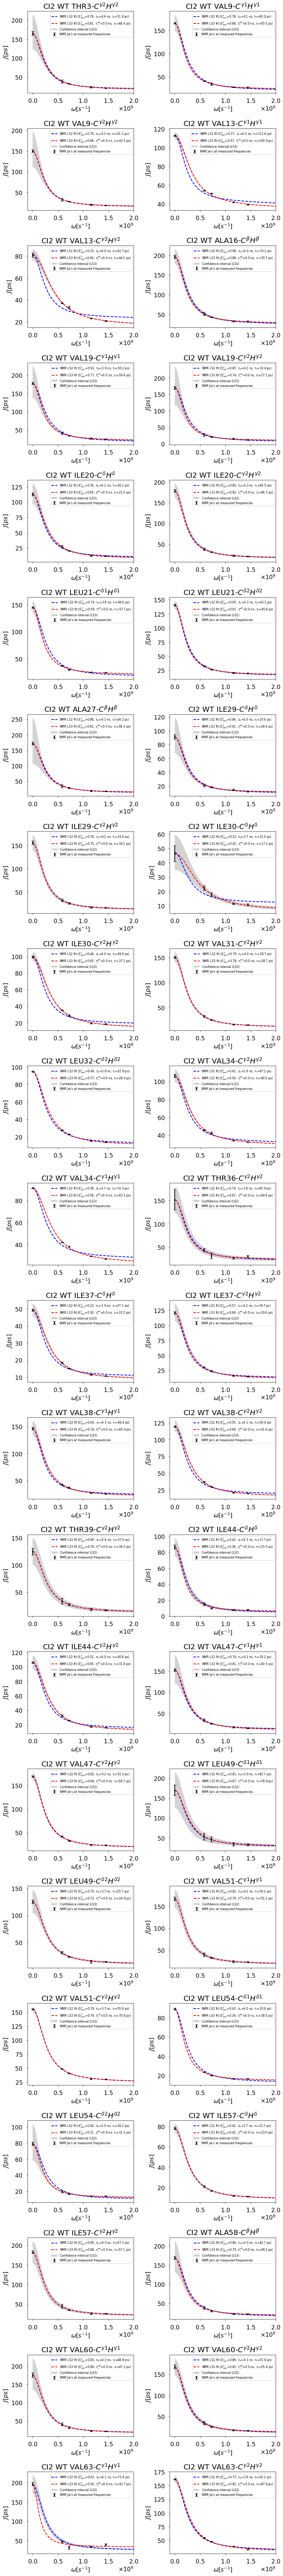

In [4]:
m = methyl_MF()

measuredfreq = m.get_freq() # get the values of the NMR frequencies used to measure the rates
m.chi2_leave_one_out()      # generate chi2 functions for minimization
from chi2_func_all import * # and import these functions
 
f = open(f"./{variant}_out.txt", 'w')
fig1, axes1 = plt.subplots(nrows = round(relax_times_exp.shape[0]/2), ncols = 2, figsize = (11, 105))

j=0
for i, ax in enumerate(axes1.flatten()):
        
    # 1. get experimental rates from the user input
    
    Rates, Rates_err = m.get_rates_and_err(i,relax_times_exp)  

    # state all the rates explicitly to be further used during minimization
    
    v_count=0
    for field in range(1,nfields+1):
        for rate in range(1,nrates+1):
            exec(f"R{rate}_exp_field{field} = Rates[{v_count}]") 
            exec(f"R{rate}_err_exp_field{field} = Rates_err[{v_count}]") 
            v_count+=1;
                 
    # 2. calculate experimental Jomegas based on the experimental rates

    Jzero_field1=m.J_0(Rates[0],Rates[1],Rates[2]) 
    Jzero_field2=m.J_0(Rates[4],Rates[5],Rates[6]) # J_0(R1,R2,R3)

    Jw_D_field1=m.J_omega_D(Rates[0],Rates[1],Rates[2]) 
    Jw_D_field2=m.J_omega_D(Rates[4],Rates[5],Rates[6]) # J_omega_D(R1,R2,R3)
    
    J2w_D_field1=m.J_2omega_D(Rates[0],Rates[1],Rates[2]) 
    J2w_D_field2=m.J_2omega_D(Rates[4],Rates[5],Rates[6]) # J_2omega_D(R1,R2,R3)

    # 3. MINIMIZATION USING CHI^2 FUNCTION Chi2_Jpre
    ## DOES NOT WORK WITH LOW NUMBERS (10^-12). CONVERTED TO PICOSECONDS with pre**2

    Jomegas_pre = np.array([Jzero_field1, Jw_D_field1, Jw_D_field2, J2w_D_field1, J2w_D_field2])*m.pre**2  # initial guess of Jomegas (x, y, z)
    
    result_all,JomegaD = m.minimize_Chi2_Jpre(Jomegas_pre,Chi2_Jpre_all)

    for field in range(1,nfields+1):
        for rate in range(1,nrates+1):
            exec(f"result_noR{rate}_field{field},JomegaD_noR{rate}_field{field} = m.minimize_Chi2_Jpre(Jomegas_pre,Chi2_Jpre_noR{rate}_field{field})")           
        
    # 4. Identify the current methyl group and it's tumbling time
          
    methID = relax_times_exp.index[j] 
    meth3ID, taum = m.get_methyl(methID,tumbling_file)
                
    # 5. Fit the experimental JomegaD values with LS2 or LS3 analytical functions        
                
    ##LS2 fit and calculation of spectral densities at measured frequencies based on the fit
    # Since R4 is obsolet, it is not required
    
    LS2_params, LS3_params, Jw_LS2, Jw_LS3 = m.LS_fit(taum,measuredfreq,JomegaD)

    index1_vec = [0,1,3,0,2,4] # rates order in Jw_LS2/Jw_LS3 
    index1=0
    
    for field in range(1,nfields+1):
        for jw in range(1,njws+1):
                exec(f"Jw{jw}LS2_field{field}=Jw_LS2[{index1_vec[index1]}]")
                exec(f"Jw{jw}LS3_field{field}=Jw_LS3[{index1_vec[index1]}]")
                index1+=1

    # 6. calculation of the (anlytical) relaxation rates 
    # based on the minimized JomegaD with chi2 (against experimental data)
    
    for field in range(1,nfields+1):
        for rate in range(1,nrates+1):
            exec(f"rate{rate}_field{field}=m.R{rate}(JomegaD[0],JomegaD[1],JomegaD[3])")  
         
    # 7. rates from LS2/LS3
    ratesLS2=[]
    ratesLS3=[]
    for model in range(2,nmodels+2): # LS2, LS3
        for field in range(1,nfields+1):
            for rate in range(1,nrates): # no R4
                    exec(f"rate{rate}LS{model}_field{field}=m.R{rate}(Jw1LS{model}_field{field},Jw2LS{model}_field{field},Jw3LS{model}_field{field})") 
                    exec(f"ratesLS{model}.append(rate{rate}LS{model}_field{field})")
                
    # 8. Use rates to find if LS2 or LS3 provides better fit (with AIC). Rate R4 is not used
    
    AIC_LS2 = m.CHI2(ratesLS2,np.concatenate((Rates[0:3],Rates[4:7])),
                              np.concatenate((Rates_err[0:3],Rates_err[4:7])) ) + 2*2 # CHI2(Rmodel,Rnmr,Rerror)
    AIC_LS3 = m.CHI2(ratesLS3,np.concatenate((Rates[0:3],Rates[4:7])),
                              np.concatenate((Rates_err[0:3],Rates_err[4:7])) ) + 3*2 # CHI2(Rmodel,Rnmr,Rerror)
    
    # 9. error estimation for the Jomega values
    # based on comparison of chi2 function (experiment vs fit) condidering all Jw's or excluding one of them
    # and taking stdv between all the combinations
    
    Jw0_ERR_MSD         = m.ERR_MSD(result_all.x[0],result_noR1_field1.x[0],result_noR2_field1.x[0],result_noR3_field1.x[0],result_noR4_field1.x[0],
                                                    result_noR1_field2.x[0],result_noR2_field2.x[0],result_noR3_field2.x[0],result_noR4_field2.x[0])
    JwD_field1_ERR_MSD  = m.ERR_MSD(result_all.x[1],result_noR1_field1.x[1],result_noR2_field1.x[1],result_noR3_field1.x[1],result_noR4_field1.x[1],
                                                    result_noR1_field2.x[1],result_noR2_field2.x[1],result_noR3_field2.x[1],result_noR4_field2.x[1])
    JwD2_field1_ERR_MSD = m.ERR_MSD(result_all.x[2],result_noR1_field1.x[2],result_noR2_field1.x[2],result_noR3_field1.x[2],result_noR4_field1.x[2],
                                                    result_noR1_field2.x[2],result_noR2_field2.x[2],result_noR3_field2.x[2],result_noR4_field2.x[2])
    JwD_field2_ERR_MSD  = m.ERR_MSD(result_all.x[3],result_noR1_field1.x[3],result_noR2_field1.x[3],result_noR3_field1.x[3],result_noR4_field1.x[3],
                                                    result_noR1_field2.x[3],result_noR2_field2.x[3],result_noR3_field2.x[3],result_noR4_field2.x[3])
    JwD2_field2_ERR_MSD = m.ERR_MSD(result_all.x[4],result_noR1_field1.x[4],result_noR2_field1.x[4],result_noR3_field1.x[4],result_noR4_field1.x[4],
                                                    result_noR1_field2.x[4],result_noR2_field2.x[4],result_noR3_field2.x[4],result_noR4_field2.x[4])
    
    err_Jws = np.array([Jw0_ERR_MSD,JwD_field1_ERR_MSD,JwD2_field1_ERR_MSD,JwD_field2_ERR_MSD,JwD2_field2_ERR_MSD]) 
      
    # 10. Monte Carlo Simulation to define parameters' (S2, tauf) errors (uncertainties) 
    
    best_model,LS_params_min,LS_params_max,params_with_std = m.MC_sim(LS2_params,LS3_params,AIC_LS2,AIC_LS3,err_Jws,measuredfreq)
   
    # 11. Save the parameters of LS fit 
    j += 1 # iterate over methyl groups
    
    if best_model=="LS2":
                
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % LS2_params[0],"±", "%.3f" % params_with_std[1],
               "tau_f", "%1.2f" % (LS2_params[1]/m.pico),"±", "%.2f" % params_with_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2)
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % LS2_params[0],"±", "%.3f" % params_with_std[1],
               "tau_f", "%1.2f" % (LS2_params[1]/m.pico),"±", "%.2f" % params_with_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2, file=f)

    elif best_model=="LS3": 
                
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % LS3_params[0],"±", "%.3f" % params_with_std[1],
               "tau_f", "%1.2f" % (LS3_params[1]/m.pico),"±", "%.2f" % params_with_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3)
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % LS3_params[0],"±", "%.3f" % params_with_std[1],
               "tau_f", "%1.2f" % (LS3_params[1]/m.pico),"±", "%.2f" % params_with_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3, file=f)

    else:
        print("no fit")
        print("no fit", file=f)
    
    # 12. Save all experimental and fitted rates, Jomegas, and fitting parameters for each methyl group
    # indices of strings for output file
    indices=["R1spec_field1","R2spec_field1","R3spec_field1","R1spec_field2","R2spec_field2","R3spec_field2", 
         "SLS2","taufLS2","R1LS2_field1","R2LS2_field1","R3LS2_field1","R1LS2_field2","R2LS2_field2","R3LS2_field2",
         "Jw1LS2_field1","Jw2LS2_field1","Jw3LS2_field1","Jw1LS2_field2","Jw2LS2_field2","Jw3LS2_field2",
         "SLS3","taurLS3","taufLS3","R1LS3_field1","R2LS3_field1","R3LS3_field1","R1LS3_field2","R2LS3_field2","R3LS3_field2",
         "Jw1LS3_field1","Jw2LS3_field1","Jw3LS3_field1","Jw1LS3_field2","Jw2LS3_field2","Jw3LS3_field2","AIC_LS2","AIC_LS3"]

    values=[rate1_field1,rate2_field1,rate3_field1,rate1_field2,rate2_field2,rate3_field2,
            LS2_params[0],LS2_params[1],rate1LS2_field1,rate2LS2_field1,rate3LS2_field1,rate1LS2_field2,rate2LS2_field2,rate3LS2_field2,
            Jw1LS2_field1,Jw2LS2_field1,Jw3LS2_field1,Jw1LS2_field2,Jw2LS2_field2,Jw3LS2_field2,
            LS3_params[0],LS3_params[2],LS3_params[1],rate1LS3_field1,rate2LS3_field1,rate3LS3_field1,rate1LS3_field2,rate2LS3_field2,rate3LS3_field2,
            Jw1LS3_field1,Jw2LS3_field1,Jw3LS3_field1,Jw1LS3_field2,Jw2LS3_field2,Jw3LS3_field2,AIC_LS2,AIC_LS3] # all results in one array
    
    
    output=pd.DataFrame(values,indices) # dataframe describing the output which will be written to the file
    output.to_csv(outputpath+"/params_"+meth3ID,sep=" ", header=False) # write values to file
    
    # 13. Plotting LS fits
    
    plotting=True
    subplots=True
    m.plot_by_one(variant,best_model,LS2_params,LS3_params,LS_params_min,LS_params_max,
                  measuredfreq,JomegaD,err_Jws,meth3ID,relax_times_exp,
                  plotting,subplots)
    
print ("Printing the figure with subplots...")   
if subplots:  
    fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
    fig1.savefig(str(outputpath+"/"+variant+"_spec_dens.pdf"), dpi = 1200, bbox_inches='tight') 

f.close()
